# Hopfield Network

This is a demonstration of classical hopfield network.

Following the blog: https://ml-jku.github.io/hopfield-layers/


In [1]:
# get images
import os

# basic data processing
import numpy as np
from numpy.typing import NDArray

# image processing
from PIL import Image
import imageio as iio


ModuleNotFoundError: No module named 'imageio'

## Classical Hopfield Network

Associative memories are one of the earliest artificial neural models dating back to the 1960s and 1970s. Best known are Hopfield Networks, presented by John Hopfield in 1982. As the name suggests, the main purpose of associative memory networks is to associate an input with its most similar pattern. In other words, the purpose is to store and retrieve patterns.

The simplest associative memory is just a sum of outer products of the N patterns $\{{x_i}\}^N_{i=1}$ that we want to store (Hebbian learning rule). In classical Hopfield Networks these patterns are polar (binary), i.e. $x_i∈\{−1,1\}^d$, where d is the length of the patterns. The corresponding weight matrix W is:

$$W=\sum_{i}^{N}{x_ix_i^T} \tag{1}$$

The weight matrix W stores the patterns, which can be retrieved starting with a state pattern $\xi$.

From now on we denote the N stored patterns as $\{{x_i}\}_{i=1}^N$ and any state pattern or state as $ξ$.

The basic synchronuous update rule is to repeatedly multiply the state pattern $ξ$ with the weight matrix W, subtract the bias and take the sign:

$$\xi^{t+1} = sign(W\xi^T - b) \tag{2}$$

where $b∈R^d$ is a bias vector, which can be interpreted as threshold for every component. The asynchronous update rule performs this update only for one component of $ξ$
 and then selects the next component for update. Convergence is reached if $ξ^{t+1}=ξ^t$.

The asynchronous version of the update rule of Eq. (2) minimizes the energy function E:

$$E = -\frac{1}{2} \xi^T W \xi + \xi^T b = -\frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d {w_{ij} \xi_i \xi_j} + \sum_{i=1}^d{b_i \xi_i} \tag{3}$$

As derived in the papers of Bruck, Goles-Chacc et al. and the original Hopfield paper, the convergence properties are dependent on the structure of the weight matrix W
 and the method by which the nodes are updated:

- For asynchronous updates with wii≥0 and wij=wji, the updates converge to a stable state.
- For synchronous updates with wij=wji, the updates converge to a stable state or a limit cycle of length 2.


In [2]:
class ClassicalHopfieldNetwork:
    def __init__(self, hid_dim:int):
        self.hid_dim = hid_dim

        self.W = np.zeros((hid_dim, hid_dim))
        self.b = np.zeros((hid_dim, 1))

    def store(self, store_patterns: NDArray):
        '''
        Stores the patterns to be memorized, save in self.W, which will be the sum of the outer products of the n patterns to be stored

        Args:
            store_patterns: a (n, hid_dim, 1) numpy array, where n is number of store patterns, each pattern is (hid_dim, 1)
        
        Return:
            None
        '''
        assert len(store_patterns.shape) == 3   # shape: (batch_size, hid_dim, 1)
        assert store_patterns.shape[1] == self.hid_dim

        for x in store_patterns:
            self.W += x@x.T



    def retrieve(self, state_pattern: NDArray):
        '''
        Retrieve the given state_pattern, by update current state until converge.

        Args:
            state_pattern: a (hid_dim, 1) numpy array

        Return:
            retrieved_pattern: retrieved_pattern
        '''
        # assert len(state_pattern.shape) == 1
        # assert state_pattern.shape[0] == self.hid_dim

        retrieved_pattern = self.update(state_pattern)

        return retrieved_pattern


    def update(self, state):
        '''
        Update by repeatedly do basic synchronuous update step: new_state = sign(W@old_state-b), until convergence.
        Convergence is reached if new energy is (almost) the same as old energy. 

        Args:
            state: a (hid_dim, 1) numpy array
        
        Return:
            cur_state: a (hid_dim, 1) numpy array
        '''
        prev_state = state
        cur_state = self.update_step(prev_state)
        while abs(self.get_energy(prev_state)-self.get_energy(cur_state))>1e-8:
            prev_state = cur_state
            cur_state = self.update_step(cur_state)  
        
        return cur_state


    def update_step(self, state):
        '''
        Perform one update step: new_state = sign(W@old_state-b)
        '''
        new_state = np.sign(self.W@state-self.b)

        return new_state


    def get_energy(self, state):
        '''
        Get energy of state: E = -1/2 * ξ.T W ξ + ξ.T b

        Return:
            a scalar
        '''
        energy = -1/2 * state.T @ self.W @ state + state.T@self.b

        return energy



## Example

We start with an illustrative example of a Hopfield Network. One input image should first be stored and then be retrieved. The input image is an image.

We preprocess the image by
- resize to shape of 64x64
- convert to black and white (mode="1")
- convert to numpy array
- map from 0,1 to -1,1
- flatten into 1d array as features

To convert the retrieved numpy array of classical hopfield network back to image, we do
- reshape from 1d array to img_size
- map from -1,1 to 0,1
- convert to Image type

(406, 407) RGBA PNG
(4096, 1)


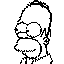

In [3]:
def preprocess_img(img, img_size=(64,64)):
    '''
    We preprocess the image by
        - resize to shape of img_size: default 64x64
        - convert to black and white (mode="1")
        - convert to numpy array
        - map from 0,1 to -1,1
        - flatten into 1d array as features
    '''
    res = img.resize(img_size)
    res = res.convert(mode='1')
    res = np.array(res)
    res = np.where(res==0, -1, 1)
    res = res.reshape((-1, 1))

    return res

def state2img(state: NDArray, img_size):
    '''
    To convert the retrieved state of classical hopfield network back to image, we do
        - reshape from 1d array to img_size
        - map from -1,1 to 0,1
        - convert to Image type
    '''
    # check the post here: https://stackoverflow.com/questions/47290668/image-fromarray-just-produces-black-image
    res = state.reshape(img_size)
    res = np.where(res==-1, 0, 1)
    res = (res*255).astype(np.uint8)
    res = Image.fromarray(res, mode='L')
    return res


# let's read in an image
IMG_FOLDER = "./images/"
img1 = Image.open("./images/homer_bw.png")
# and see it's shape, mode, format
print(img1.size, img1.mode, img1.format)
# and take a look at it
# img1.show()

# now, preprocess it
img_size = 64, 64
# img_size = 4, 4
train_img1 = preprocess_img(img1, img_size)
print(train_img1.shape)

# convert back and check it's the same
state2img(train_img1, img_size)


Now let's try to store the image and retrieve it with half of the image masked.

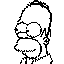

In [4]:
size = 64,64

# preprocess the image
processed_img1 = preprocess_img(img1, size) # (64*64, 1)

# batch it
store_patterns = np.expand_dims(processed_img1, axis=0)

# get a masked image to test
masked_img1 = processed_img1.copy()
masked_img1[64*64//2:] = 0
# print(masked_img1.shape)
# state2img(masked_img1, (64,64)).show()

# get our model
hopfield = ClassicalHopfieldNetwork(64*64)

# store the image
hopfield.store(store_patterns)
# print(hopfield.W)

# retrieve the masked img
retrieved_img1 = hopfield.retrieve(masked_img1)
# print(retrieved_img1)

# convert the retrieved numpy array back to Image
res_img = state2img(retrieved_img1, (64,64))
res_img


Now let's see if we store multiple patterns, how would that affect our retrieve.

In [ ]:
def color2bw(img, thr=150):
    '''
    Convert color image to black white image with PIL Image

    Args:
        img: a PIL Image
        thr: a threshold for cutting between black and white pixel, default 150
    
    Return:
        res: a PIL image of mode "L"
    '''
    res = img.convert('L').point(lambda x: 255 if x>thr else 0)
    return res

def get_bw_imgs(img_dir, pt_thr=150):
    '''
    Given img_dir, return all image files converted to L mode PIL black white images in that dir

    Args:
        img_dir: a dir path containing images for training
        pt_thr: threshold for color2bw()
    Return:
        train_imgs: "L" mode black white PIL images
    '''
    train_imgs = os.listdir(img_dir)
    train_imgs = [img_dir+f for f in train_imgs if os.path.isfile(img_dir+f)]
    train_imgs = [Image.open(img) for img in train_imgs]
    train_imgs = [color2bw(img, pt_thr) for img in train_imgs]
    return train_imgs


In [ ]:
# get model
hopfield2 = ClassicalHopfieldNetwork(64*64)

# get multiple store images
TRAIN_IMG_PATH = IMG_FOLDER+'train/'
train_imgs = get_bw_imgs(TRAIN_IMG_PATH)
train_imgs[1].show()    # take a look at one of it

# TBD: mask some train img and try retrieve
# can do this by writing a new function doing the masking job


# The End